<a href="https://colab.research.google.com/github/faizanahemad/eva/blob/master/assignment-14/DN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Resources**

- XLA

    - [Google Notebook example](https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/g3doc/tutorials/xla_compile.ipynb)

    - [Blog](https://medium.com/@xianbao.qian/use-xla-with-keras-3ca5d0309c26)
    
- Mixed Precision

- Augmentation Libs
    - [imgaug](https://github.com/aleju/imgaug)
    - [albumentations](https://github.com/albu/albumentations)
    - [Automold](https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library)
    - [Tensorflow Examples](https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/)

# Imports

In [2]:
import numpy as np
import skimage
print(np.__version__)
print(skimage.__version__)

import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import gc
print(tf.__version__)
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
% matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os

import imgaug.augmenters as iaa
from matplotlib import cm
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,RandomFog,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, ChannelDropout, ChannelShuffle,RandomContrast
)

1.17.0
0.15.0
1.14.0


In [3]:
tf.enable_eager_execution()
# tf.random.set_random_seed(1234)

In [4]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.5 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}
cutout_proba = 0.25


mixed_precision = False
xla_enabled = False

jobs = int(os.cpu_count()/2)

In [5]:
# Half Precision Checks
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True

print("TensorFlow version is", tf.__version__)

try:
    # check and assert TensorFlow >= 1.14
    tf_version_list = tf.__version__.split(".")
    if int(tf_version_list[0]) < 2:
        assert int(tf_version_list[1]) >= 14
except:
    print("TensorFlow 1.14.0 or newer is required.")
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
assert check_tensor_core_gpu_present() == True

TensorFlow version is 1.14.0
Tensor Core GPU Present: True


In [6]:
if xla_enabled:
    config = tf.ConfigProto()
    jit_level = tf.OptimizerOptions.ON_1
    config.graph_options.optimizer_options.global_jit_level = jit_level

    sess = tf.Session(config=config)
    tf.keras.backend.set_session(sess)


In [7]:

def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.1, r_1=0.4, r_2=1 / 0.4, 
                      v_l=-1,v_h=1,
                      max_erasures_per_image=1, pixel_level=True):
    """

    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        shape = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        mx = np.random.randint(1, max_erasures_per_image + 1)
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            else:
                c = np.random.uniform(v_l, v_h)

#             input_img = tf.Variable(input_img)
#             input_img = input_img[top:top + h, left:left + w, :].assign(tf.constant(c, shape=(h, w, img_c)))
            input_img[top:top + h, left:left + w, :] = c
#         
        return input_img

    return eraser




In [8]:
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random

class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.
        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)
        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.8, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]


    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"

    

class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        # from https://stackoverflow.com/questions/5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
        def rotate_with_fill(img, magnitude):
            rot = img.convert("RGBA").rotate(magnitude)
            return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode)

        func = {
            "shearX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "shearY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
                Image.BICUBIC, fillcolor=fillcolor),
            "translateX": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, magnitude * img.size[0] * random.choice([-1, 1]), 0, 1, 0),
                fillcolor=fillcolor),
            "translateY": lambda img, magnitude: img.transform(
                img.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * img.size[1] * random.choice([-1, 1])),
                fillcolor=fillcolor),
            "rotate": lambda img, magnitude: rotate_with_fill(img, magnitude),
            # "rotate": lambda img, magnitude: img.rotate(magnitude * random.choice([-1, 1])),
            "color": lambda img, magnitude: ImageEnhance.Color(img).enhance(1 + magnitude * random.choice([-1, 1])),
            "posterize": lambda img, magnitude: ImageOps.posterize(img, magnitude),
            "solarize": lambda img, magnitude: ImageOps.solarize(img, magnitude),
            "contrast": lambda img, magnitude: ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "sharpness": lambda img, magnitude: ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "brightness": lambda img, magnitude: ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])),
            "autocontrast": lambda img, magnitude: ImageOps.autocontrast(img),
            "equalize": lambda img, magnitude: ImageOps.equalize(img),
            "invert": lambda img, magnitude: ImageOps.invert(img)
        }

        # self.name = "{}_{:.2f}_and_{}_{:.2f}".format(
        #     operation1, ranges[operation1][magnitude_idx1],
        #     operation2, ranges[operation2][magnitude_idx2])
        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]


    def __call__(self, img):
        if random.random() < self.p1: img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2: img = self.operation2(img, self.magnitude2)
        return img


# Network Functions

In [9]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [10]:
class ConvBN(tf.keras.Model):
    def __init__(self, c_out, kernel_size=3):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=kernel_size, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))

In [11]:
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super().__init__()
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h

In [12]:
class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ResBlk(c*4, pool)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight

    def call(self, x, y):
        h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

# Data Preparation

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='median')

# x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [14]:
print(gc.collect())

model = DavidNet(weight=0.125)
batches_per_epoch = len_train//BATCH_SIZE + 1

# lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS-3, EPOCHS-2,EPOCHS-1, EPOCHS], [0.001, LEARNING_RATE, LEARNING_RATE/5, LEARNING_RATE/10,LEARNING_RATE/40,LEARNING_RATE/100])[0]



global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

if mixed_precision:
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)

data_aug1 = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
data_aug2 = lambda x,y: (tf.image.random_hue(tf.image.random_brightness(x,max_delta=0.05),max_delta=0.05),y)
data_aug3 = lambda x, y: (tf.image.random_contrast(tf.image.random_saturation(x, 0.9, 1.1),0.9, 1.1), y)
data_aug = lambda x, y:data_aug1(*data_aug2(*data_aug3(x,y)))

# rot90 = lambda x,y: (tf.image.rot90(x, np.random.choice([0,1,3],p=[1-rot90_proba,rot90_proba/2,rot90_proba/2])),y)

cutout_fn = get_cutout_eraser(p=1.0, pixel_level=True)

def batch_cut(imgs, epoch,cutout_proba=cutout_proba,copy=False):
    if copy:
        imgs = np.copy(imgs)
    for i,im in enumerate(imgs):
        p_1 = np.random.rand()
        if p_1 > cutout_proba:
            continue
        else:
            imgs[i] = cutout_fn(im)
    return imgs

def cifar10_augs(imgs,epoch):
    policy = CIFAR10Policy()
    for i,im in enumerate(imgs):
        im = Image.fromarray(np.uint8(im),'RGB')
        im = policy(im)
        imgs[i] = np.array(im)
    return imgs


15


In [15]:
def batch_cut_par(imgs, epoch):
    shape_1 = imgs.shape
    def probabilistic_cut(im):
        p_1 = np.random.rand()
        if p_1 > cutout_proba:
            return im
        else:
            return cutout_fn(im)
    imgs = Parallel(n_jobs=4, backend="loky")(delayed(probabilistic_cut)(x) for x in iter(imgs))
    imgs = np.stack(imgs)
    shape_2 = imgs.shape
    assert shape_1==shape_2
    return imgs

def cifar10_augs_par(imgs,epoch):
    policy = CIFAR10Policy()
    shape_1 = imgs.shape
    
        
    def cifar10_augmentation(im):
        im = Image.fromarray(np.uint8(im),'RGB')
        im = policy(im)
        return np.array(im)
    imgs = Parallel(n_jobs=4, backend="loky")(delayed(cifar10_augmentation)(x) for x in imgs)
    imgs = np.stack(imgs)
    shape_2 = imgs.shape
    assert shape_1==shape_2
    return imgs


<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'dog')

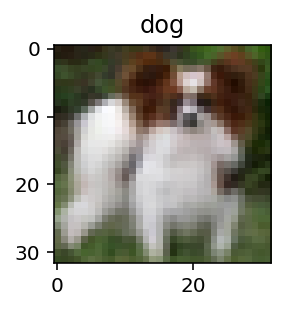

<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'dog')

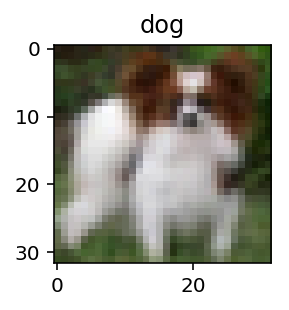

W0813 19:52:06.539015 139631916156736 deprecation.py:323] From <ipython-input-17-eb3e0f26b9d4>:23: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


97 1


<Figure size 144x144 with 0 Axes>

Text(0.5, 1.0, 'dog')

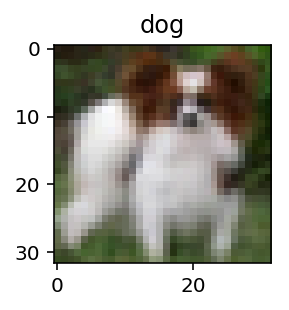

In [17]:
exampleId = np.random.randint(0,len_train)
example = x_train[exampleId]


plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
ex = (example - np.min(example))/(np.max(example)-np.min(example))
plt.imshow(ex)
plt.show()


example = cifar10_augs(np.array([example]),14)


plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
ex = example[0]
ex = (ex - np.min(ex))/(np.max(ex)-np.min(ex))
plt.imshow(ex)
plt.show()

ts = tf.data.Dataset.from_tensor_slices((example, np.array([y_train[exampleId]]))).map(data_aug1, num_parallel_calls=tf.data.experimental.AUTOTUNE).prefetch(1)
x,y = next(ts.make_one_shot_iterator())
x,y = x.numpy(),y.numpy()
example=x
print(np.max(example),np.min(example))
ex = (example - np.min(example))/(np.max(example)-np.min(example))
plt.figure(figsize=(2,2))
plt.title(classes[y_train[exampleId]])
plt.imshow(ex)
plt.show()

# Augmentation

Use one of Strategy 1 or Strategy 2

## Strategy 1

In [18]:
print(gc.collect())
train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))
normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here   
t1 = time.time()
train_data = {}
for epoch in range(EPOCHS):
    
    if epoch<=3:
        xt = normalize(x_train)
    else:
        xt = np.copy(x_train)
        xt = cifar10_augs(xt,epoch)
        xt = normalize(xt)
        cp = np.interp([epoch], [0.0, 0.0, 0.2, 0.1], [4,8,15,23])[0]
        xt = batch_cut(xt, epoch, cutout_proba=cp, copy=False)
        
    
    train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
    
    
    i = 0
    for x,y in train_set:
        assert x.numpy().shape[0]==len_train
        train_set = (x.numpy(),y.numpy())
        i = i+1
    assert i==1
    train_data[epoch] = train_set
    
    
    if epoch%2==1:
        print("Epoch = ",epoch," Time = ",(time.time()-t1))
t2 = time.time()
"%.1f" %(t2-t1)


3603
Epoch =  1  Time =  19.271154642105103
Epoch =  3  Time =  37.827486991882324
Epoch =  5  Time =  86.56631422042847
Epoch =  7  Time =  135.45091605186462
Epoch =  9  Time =  184.2867729663849
Epoch =  11  Time =  233.23536705970764
Epoch =  13  Time =  282.1320948600769
Epoch =  15  Time =  330.9339294433594
Epoch =  17  Time =  379.6729657649994
Epoch =  19  Time =  428.89880871772766
Epoch =  21  Time =  477.76410007476807
Epoch =  23  Time =  526.4346554279327


'526.4'

## Strategy 2

In [20]:
print(gc.collect())
train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))
normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here   
t1 = time.time()
train_data = {}
for epoch in range(EPOCHS):
    
    if epoch<=1:
        xt = normalize(x_train)
        train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug1, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
    elif epoch<=5:
        xt = normalize(x_train)
        cp = np.interp([epoch], [0.1, 0.4], [2,5])[0]
        xt = batch_cut(xt, epoch, cutout_proba=cp, copy=False)
        train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
    else:
        xt = np.copy(x_train)
        xt = cifar10_augs(xt,epoch)
        xt = normalize(xt)
        cp = np.interp([epoch], [0.0,0.0, 0.3, 0.2], [6,7,14,23])[0]
        xt = batch_cut(xt, epoch, cutout_proba=cp, copy=False)
        train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
    
    
    i = 0
    for x,y in train_set:
        assert x.numpy().shape[0]==len_train
        train_set = (x.numpy(),y.numpy())
        i = i+1
    assert i==1
    train_data[epoch] = train_set
    
    
    if epoch%2==1:
        print("Epoch = ",epoch," Time = ",(time.time()-t1))
t2 = time.time()
"%.1f" %(t2-t1)


3572
Epoch =  1  Time =  17.26221990585327
Epoch =  3  Time =  43.91580605506897
Epoch =  5  Time =  70.45851111412048
Epoch =  7  Time =  117.54404640197754
Epoch =  9  Time =  163.95603489875793
Epoch =  11  Time =  210.48803973197937
Epoch =  13  Time =  256.685560464859
Epoch =  15  Time =  303.18155097961426
Epoch =  17  Time =  349.9125978946686
Epoch =  19  Time =  396.7286605834961
Epoch =  21  Time =  443.3264317512512
Epoch =  23  Time =  489.8198003768921


'489.8'

# Persist/Read Train Set

## Persist

In [ ]:
import dill as pickle
with open('train_data_s1.pkl', 'wb') as file:
    pickle.dump(train_data, file)

## Read 

In [18]:
import dill as pickle
with open('train_data_s1.pkl', 'rb') as file:
    train_data = pickle.load(file)

# Model Running / Training Loop

In [19]:
print(gc.collect())
t = time.time()
t_last = time.time()
train_accs = []
test_accs = []
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(1)

for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    train_set = train_data[epoch]
    train_set = tf.data.Dataset.from_tensor_slices(train_set).batch(BATCH_SIZE).prefetch(1)
    tf.keras.backend.set_learning_phase(1)
    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * (WEIGHT_DECAY/(epoch+1)) * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

    tf.keras.backend.set_learning_phase(0)
    for (x, y) in test_set:
        loss, correct = model(x, y)
        test_loss += loss.numpy()
        test_acc += correct.numpy()

    t2 = time.time()
    epoch_time = t2 - t_last
    t_last = t2
    train_accs.append(train_acc / len_train)
    test_accs.append(test_acc / len_test)
    print("epoch = %2s"%epoch,'lr: %.4f' % (lr_schedule(epoch+1)), '||train=> loss: %.3f' %(train_loss / len_train), 'acc: %.3f' % (train_acc / len_train), '||val=> loss: %.3f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"%.2fs"%(epoch_time), '%.2fs'%(t2 - t))
    
    

# 
    
# 0.936

# epoch = 11 lr: 0.2644 | train loss: 0.3852 train acc: 0.866 val loss: 0.2993 val acc: 0.900 epoch time: 14.99 time: 185.31

0
epoch =  0 lr: 0.1008 ||train=> loss: 1.507 acc: 0.460 ||val=> loss: 1.185 val acc: 0.599 20.28s 20.28s
epoch =  1 lr: 0.2006 ||train=> loss: 0.770 acc: 0.729 ||val=> loss: 1.146 val acc: 0.645 15.06s 35.34s
epoch =  2 lr: 0.3004 ||train=> loss: 0.609 acc: 0.791 ||val=> loss: 1.464 val acc: 0.611 14.95s 50.29s
epoch =  3 lr: 0.4002 ||train=> loss: 0.489 acc: 0.830 ||val=> loss: 0.601 val acc: 0.801 14.94s 65.23s
epoch =  4 lr: 0.5000 ||train=> loss: 1.047 acc: 0.662 ||val=> loss: 0.743 val acc: 0.761 15.01s 80.24s
epoch =  5 lr: 0.4750 ||train=> loss: 0.747 acc: 0.740 ||val=> loss: 0.646 val acc: 0.792 14.99s 95.23s
epoch =  6 lr: 0.4500 ||train=> loss: 0.650 acc: 0.774 ||val=> loss: 0.536 val acc: 0.823 14.95s 110.18s
epoch =  7 lr: 0.4250 ||train=> loss: 0.587 acc: 0.797 ||val=> loss: 0.444 val acc: 0.855 14.99s 125.17s
epoch =  8 lr: 0.4000 ||train=> loss: 0.543 acc: 0.811 ||val=> loss: 0.417 val acc: 0.862 15.08s 140.25s
epoch =  9 lr: 0.3750 ||train=> loss: 0.506 acc: 0.824 ||va

In [20]:
def make_plots():
    plt.figure(figsize=(12,4))
    plt.title("Train acc = %.3f, Test acc = %.3f"%(train_accs[-1],test_accs[-1]))
    plt.plot(train_accs)
    plt.plot(test_accs)
    plt.show()


    plt.figure(figsize=(12,4))
    plt.title("Train acc = %.3f, Test acc = %.3f"%(train_accs[-1],test_accs[-1]))
    plt.plot(list(range(2,len(train_accs))),train_accs[2:])
    plt.plot(list(range(2,len(test_accs))),test_accs[2:])
    plt.show()
    return

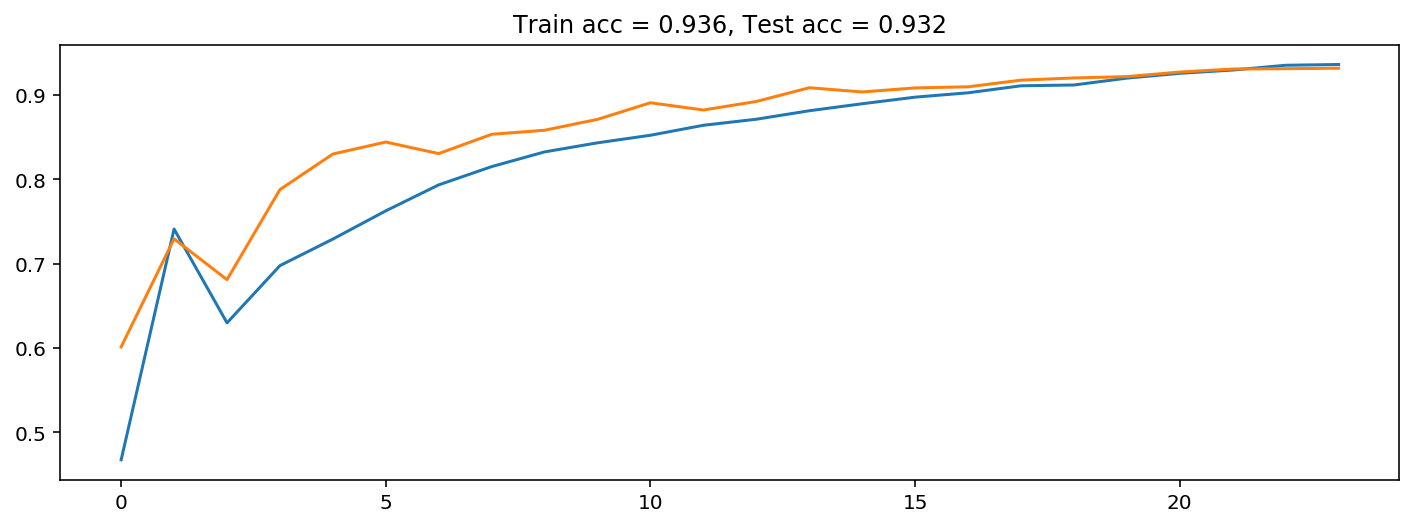

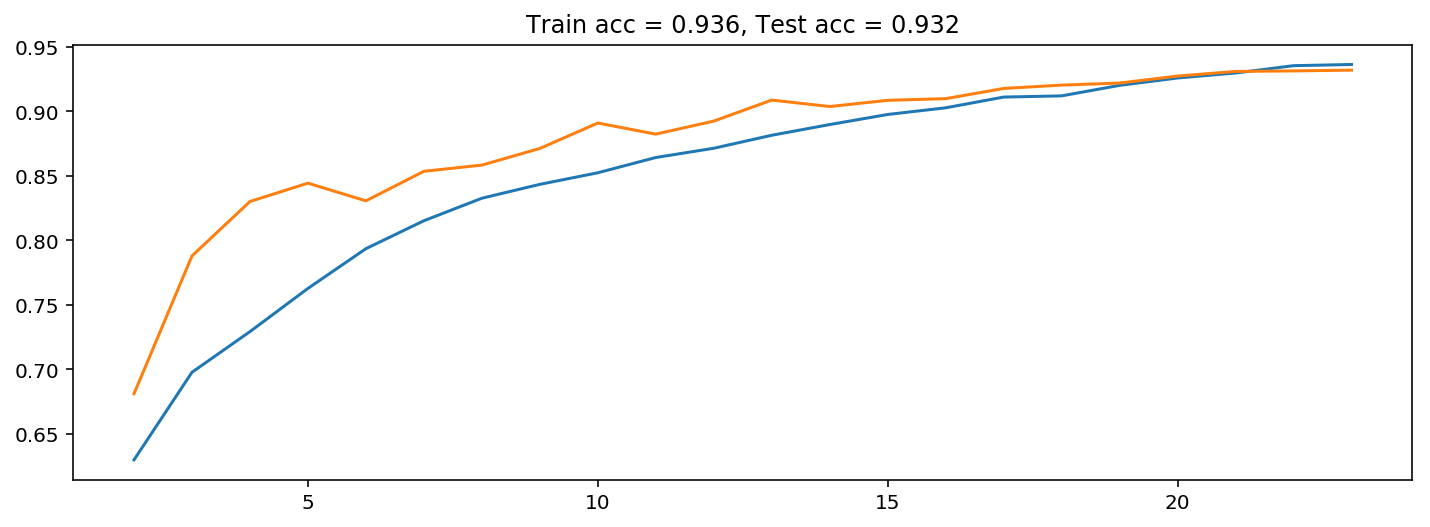

In [21]:
make_plots()